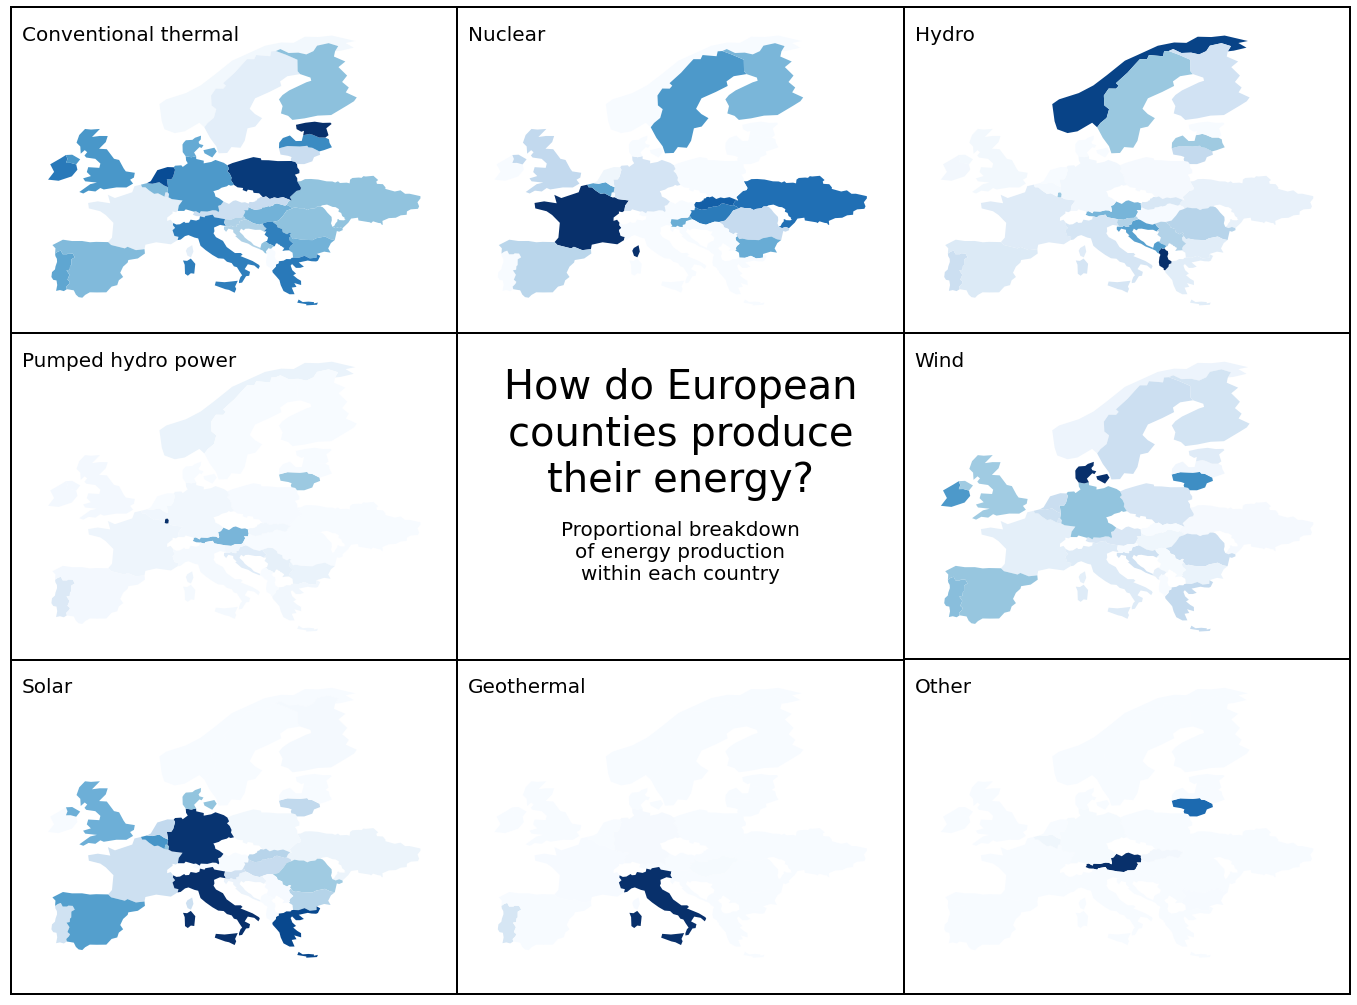

In [1]:
# standard imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline


# get and prepare populations of European countries--copy/paste from wikipedia
# https://en.wikipedia.org/wiki/List_of_European_countries_by_population#Table
# I didn't end up using this, but I'll leave it in for reference
population = pd.read_csv('population.csv')
population.Country = population.Country.str.replace(r'\[.*\]','')
population.Country = population.Country.str.strip()
population.drop(['Rank', 'UN', 'Unnamed: 4', 'Regional', 'Source'], axis=1, inplace=True)
population.rename(columns={'National statistic': 'population'}, inplace=True)
population.set_index('Country', inplace=True)
population = population.iloc[1:]
population.population = population.population.str.replace(',','').astype(int)

# get `energy_types.csv`
energy = pd.read_csv('energy_types.csv')
# calculate proportions for each country's energy production
for country in energy.country.unique():
    for source in energy['type'].unique():
        energy.loc[(energy.country==country) & (energy.type==source), '2018_prop'] =\
            energy.loc[(energy.country==country) & (energy.type==source), '2018']/\
                energy.loc[(energy.country==country), '2018'].sum()

# get shapes for European countries
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))

europe = world[world.continent=="Europe"].copy()

# clean up for joins
europe.name.replace({'Czechia': 'Czech Republic', 'Bosnia and Herz.': 'Bosnia and Herzegovina'}, inplace=True)
energy.loc[energy.country=="EL", 'country_name'] = "Greece"
energy.loc[energy.country=="UK", 'country_name'] = "United Kingdom"
europe = europe.join(population, on='name')#.name.sort_values()


# ========================================================================================================
# plotting
# ========================================================================================================

fig, axes = plt.subplots(3,3,figsize=(24,24))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=-0.5)

def make_map(x, y, source=None):
    "function for plotting maps, keeping formatting the same"
    
    if source is not None:
        # prepare the map for that energy source
        data = europe.join(
            energy[energy['type']==source].set_index('country_name'), on='name')
        
        data.plot('2018_prop', ax=axes[x,y], cmap="Blues")
        
        axes[x,y].set_xlim(-15,45)
        axes[x,y].set_ylim(30,75)
        axes[x,y].set_xticks([])
        axes[x,y].set_yticks([])
        axes[x,y].annotate(source, (0.025,0.90), xycoords='axes fraction', size=20)
        
        # thick borders between maps
        for axis in ['top','bottom','left','right']:
            axes[x,y].spines[axis].set_linewidth(2)
        
    else:
        # centre square--title
        # hack job: plot a blank map to size the central axis object correctly
        data = europe.join(
            energy[energy['type']=='Other'].set_index('country_name'), on='name')
        
        data.plot(ax=axes[x,y], color='white')
        for axis in ['top','bottom','left','right']:
            axes[x,y].spines[axis].set_linewidth(2)
       
        axes[x,y].set_xlim(-15,45)
        axes[x,y].set_ylim(30,75)  
        axes[x,y].set_xticks([])
        axes[x,y].set_yticks([])
        
        # Use annotation to set the title
        axes[x,y].annotate("How do European\ncounties produce\ntheir energy?", 
                           (0.5, 0.5), 
                           xycoords='axes fraction',
                           horizontalalignment='center',
                           verticalalignment='bottom',
                           size=40)
        
        axes[x,y].annotate("Proportional breakdown\nof energy production\nwithin each country",
                           (0.5, 0.25),
                           xycoords='axes fraction',
                           horizontalalignment='center',
                           verticalalignment='bottom',
                           size=20)
        
        
# generate the maps!
make_map(0,0,'Conventional thermal')
make_map(0,1,'Nuclear'),
make_map(0,2,'Hydro')
make_map(1,0, 'Pumped hydro power')
make_map(1,2, 'Wind')
make_map(2,0, 'Solar')
make_map(2,1, 'Geothermal')
make_map(2,2, 'Other')
make_map(1,1, None)
    
plt.savefig(fname='european_energy_production.png', format='png', trasparant=False)
plt.show()